<a href="https://colab.research.google.com/github/stephenkiilu/Cassava_Kaggle/blob/master/Ademola_Abiodun_Saheed_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import image
import matplotlib.pyplot as plt

In [3]:
a=2+2
a

4

In [ ]:
img =image.imread("/content/test-img-3757.jpg")
img.shape

(666, 500, 3)

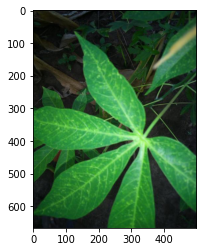

In [ ]:
plt.imshow(img, cmap="hot")
plt.show()

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c ammi-2021-convnets

100% 2.30G/2.30G [00:58<00:00, 77.9MB/s]
100% 2.30G/2.30G [00:58<00:00, 42.4MB/s]


In [ ]:
# ! unzip ammi-2021-convnets

In [ ]:
#Imports
import os
import sys
import glob
import torch
import torchvision

import numpy    as np
import pandas as pd
import datetime as dt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot   as plt

from PIL               import Image
from torch.utils.data  import Dataset
from torch.autograd    import Variable
from torch.optim       import lr_scheduler

from torch.utils.data  import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision       import transforms, datasets, models
from os                import listdir, makedirs, getcwd, remove
from os.path           import isfile, join, abspath, exists, isdir, expanduser


%matplotlib inline

In [ ]:
data_path = "../content/ammi-2021-convnets"
train_path = join(data_path, "/content/train/train")
test_path = join(data_path,"/content/test/test")
extraimage_path = join(data_path, "/content/extraimages")

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# BASE_DIR = "../input/cassava-leaf-disease-classification/"

# train = pd.read_csv(BASE_DIR+'train.csv')
# train.head()

In [ ]:
# Transformations for both the training and testing data
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Do data transforms here, Try many others
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([ transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])

normalize = transforms.Normalize(mean=mean, std=std)

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
            
        return im.view(3, 224, 224), classCategory

In [ ]:
train_data = CassavaDataset(train_path, transform=train_transforms)
test_data = CassavaDataset(test_path, transform=test_transforms)

In [ ]:
len(train_data)

5656

In [ ]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                             sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                             sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define Models 

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 2, padding = 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        #Block 2
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        #Block 3
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        # #Block 4
        # self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 2)
        # self.relu3 = nn.ReLU()
        # self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        # last fully-connected layer
        self.fc = nn.Linear(32*3*3, num_classes)


    def forward(self, input):

        x = self.maxpool1(self.relu1(self.conv1(input)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.maxpool3(self.relu3(self.conv3(x)))
        # x = self.maxpool4(self.relu4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


model = Classifier(5)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2 , momentum =0.1)

In [ ]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model.""" 
    
    # Make sure model is in training mode.
    model.train()
    
    # Move model to the device (CPU or GPU).
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None

    print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
        
      # Loop over data.
      for batch_idx, (features, target) in enumerate(data_loader):
            
          # Forward pass.
        output = model(features.to(device))
        loss = criterion(output.to(device), target.to(device))

          # Backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # NOTE: It is important to call .item() on the loss before summing.
        if ema_loss is None:
            ema_loss = loss.item()
        else:
            ema_loss += (loss.item() - ema_loss) * 0.01 

      # Print out progress the end of epoch.
      print('Epoch: {} \tLoss: {:.6f}'.format(epoch, ema_loss),)
  

In [ ]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        
        # Loop over test data.
        for features, target in data_loader:
          
            # Forward pass.
            output = model(features.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(data_loader.dataset)
    print(f'Test accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)')
    torch.save(model.state_dict(), 'model.ckpt')
    return percent

In [ ]:
num_epochs = 10
train(model, criterion, train_loader, optimizer, num_epochs=num_epochs)
test(model, valid_loader)

----- Training Loop -----
Epoch: 0 	Loss: 1.408009
Epoch: 1 	Loss: 1.351065
Epoch: 2 	Loss: 1.338677
Epoch: 3 	Loss: 1.325675
Epoch: 4 	Loss: 1.317533
Epoch: 5 	Loss: 1.313608
Epoch: 6 	Loss: 1.310697
Epoch: 7 	Loss: 1.307537
Epoch: 8 	Loss: 1.299569
Epoch: 9 	Loss: 1.285513
----- Model Evaluation -----
Test accuracy: 525 / 5656 (9%)


9.282178217821782

In [ ]:
# test(model, test_loader)

In [ ]:
# Make submission here